In [81]:
"""
Dual Momentum Strategy
"""
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
df = pd.read_csv('./tmp.csv')
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
tickers = list(df.columns)

In [83]:
start_date = '2021-08-01'
end_date = '2022-08-01'

data = yf.download(tickers, start_date, end_date)['Adj Close']

[*********************100%%**********************]  360 of 360 completed


## Momentum

In [84]:
# Data Load

ret = data.iloc[-1]/data.iloc[0]-1
ret_df = pd.DataFrame({'ticker': ret.index, 'return': ret})
ret_df = ret_df.reset_index(drop=True)

In [85]:
# 수익률 상위 20개 종목 추출

ret_rank = ret_df['return'].rank(axis=0, ascending=False)
rank_df = ret_df[ret_rank <= 20]

In [86]:
# 상위 20개 종목 주가 불러오기

df_mmt = yf.download(list(rank_df['ticker']), start_date, end_date)['Adj Close']

[*********************100%%**********************]  20 of 20 completed


In [87]:
import statsmodels.api as sm
import numpy as np

data_ret = data.pct_change().iloc[1:]
data_cum = np.log(1 + data_ret).cumsum()

x = np.array(range(len(data_ret)))
y = data_cum.iloc[:, 1].values

In [88]:
x = np.array(range(len(data_ret)))
k_ratio = {}

for i, column in enumerate(data_ret.columns):
    y = data_cum.iloc[:, i].values

    reg = sm.OLS(y, x).fit()
    result = float(reg.params/reg.bse)

    k_ratio[column] = result

k_ratio = pd.DataFrame.from_dict(k_ratio, orient='index').reset_index()
k_ratio.columns = ['ticker', 'K_ratio']

/var/folders/zc/yxghmczd4c70ghhrdh80r9cw0000gn/T/ipykernel_2442/760998214.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = float(reg.params/reg.bse)


In [89]:
krat_df = ret_df.merge(k_ratio, how='left', on='ticker')
krat_df_rank = krat_df['K_ratio'].rank(axis=0, ascending=False)
krat_df_20 = krat_df[krat_df_rank <= 20]

[*********************100%%**********************]  20 of 20 completed


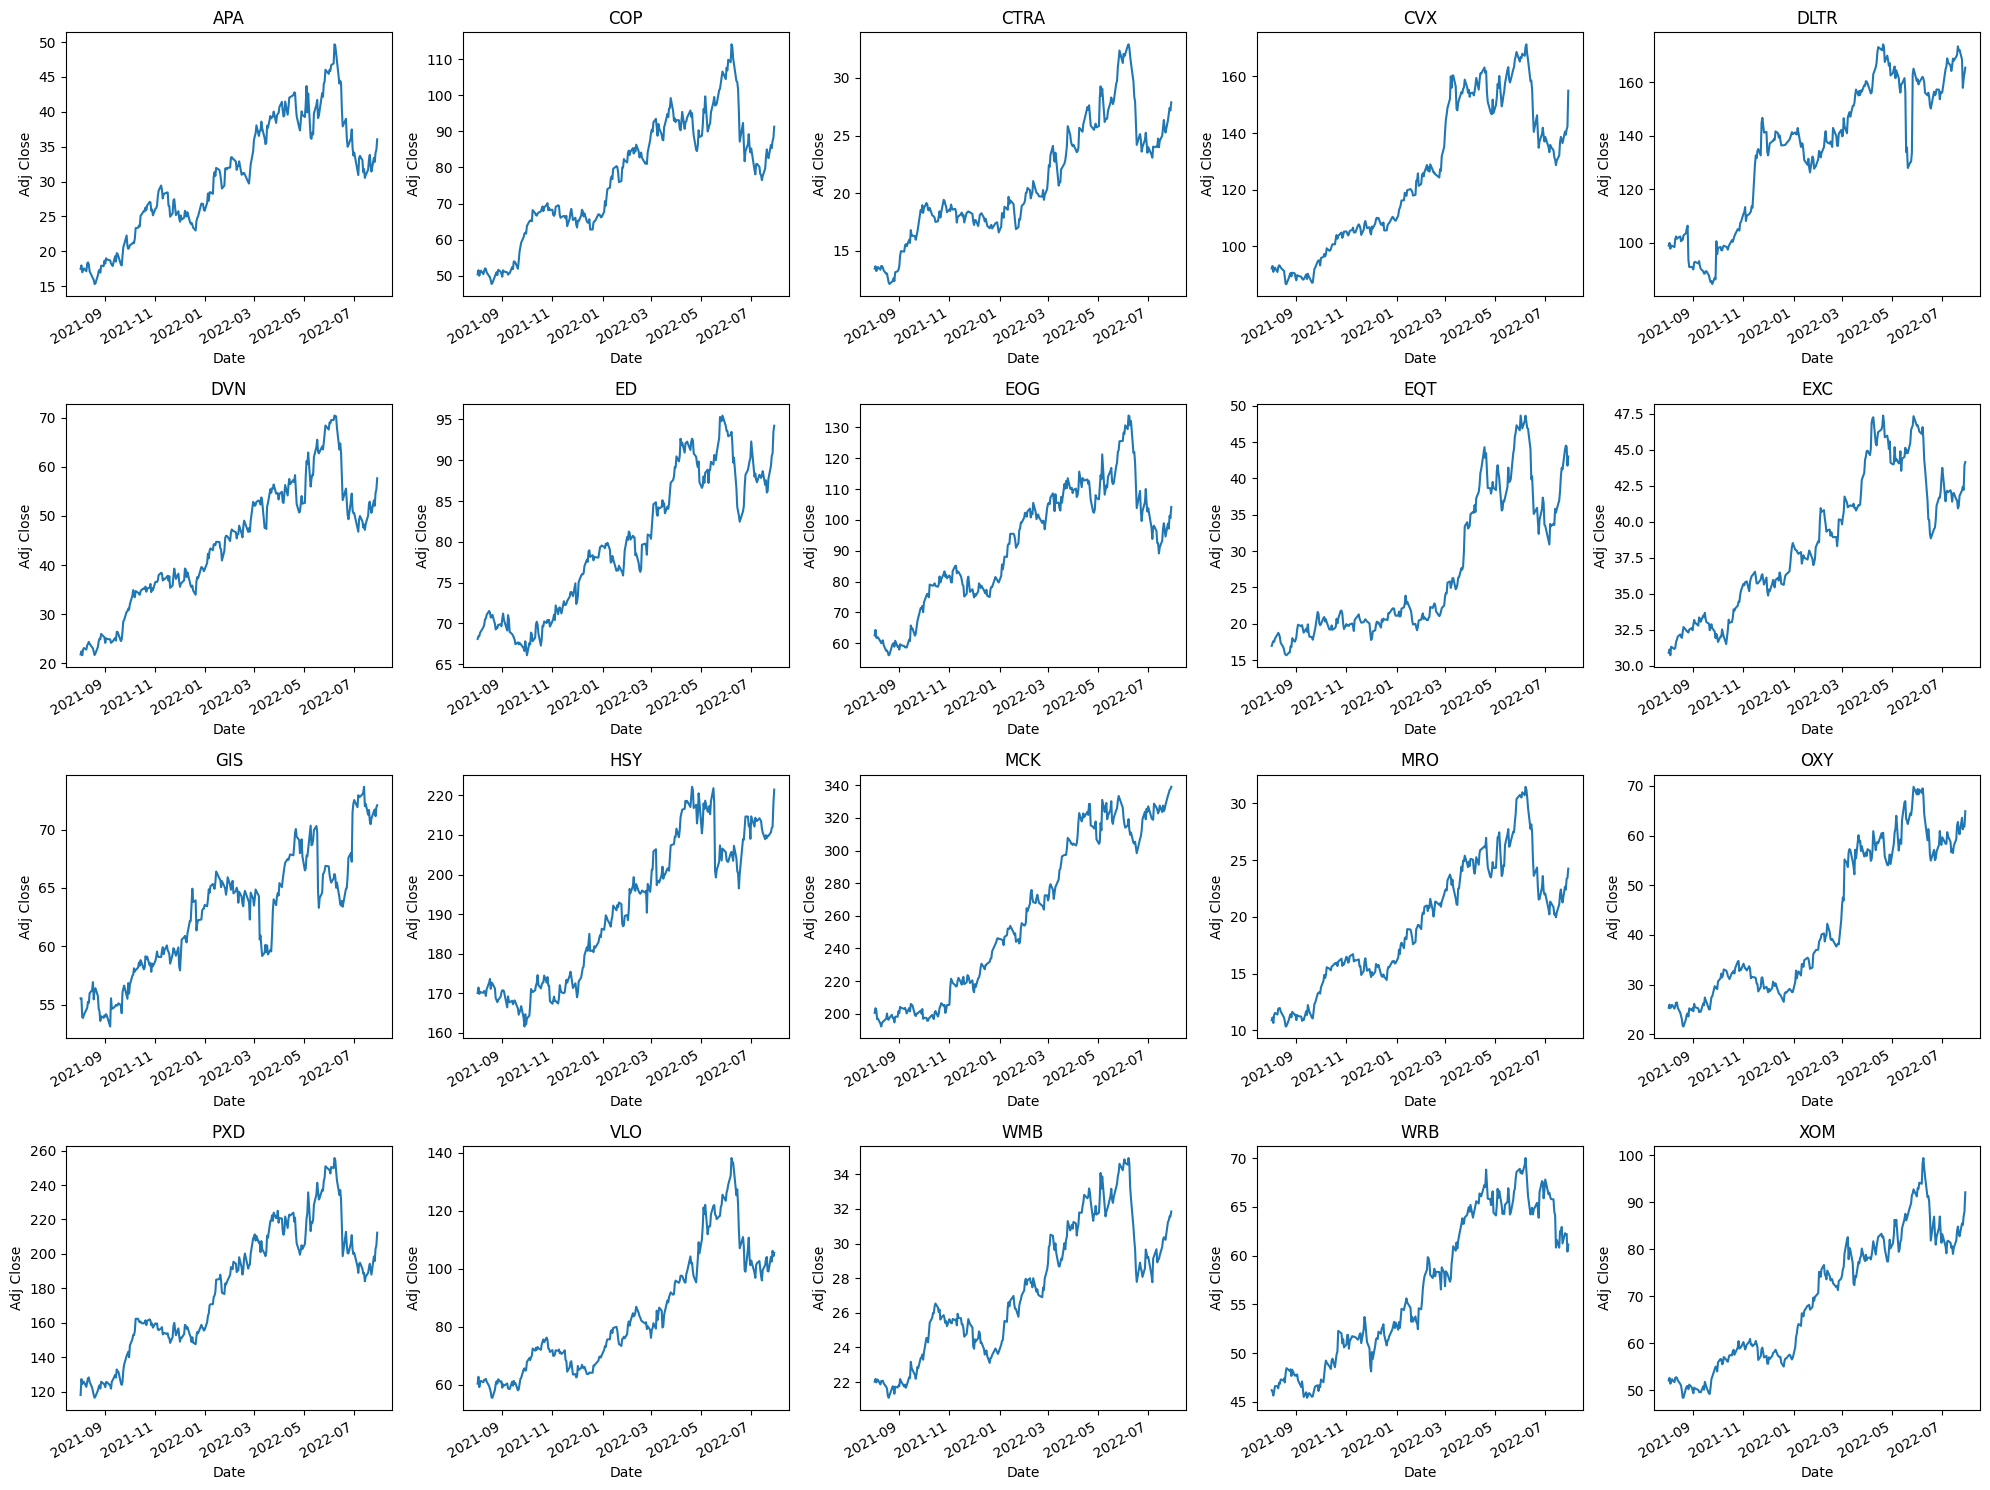

In [90]:
# Plot 찍어보기
# 상위 20개 종목 주가 불러오기
# 모멘텀 장,단점 -> 듀얼 모멘텀의 한계를 보완한 새로운 전략으로 종목 선정 후 필터링

df_mmt = yf.download(list(krat_df_20['ticker']), start_date, end_date)['Adj Close']

num_plots = len(df_mmt.columns)
num_cols = 5
num_rows = (num_plots // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
fig.subplots_adjust(hspace=0.5)

for i, (col, ax) in enumerate(zip(df_mmt.columns, axes.flatten())):
    df_mmt[col].plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Date')
    ax.set_ylabel('Adj Close')

for i in range(num_plots, num_rows * num_cols):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

## RSI

In [91]:
# RSI 지표 추가하기, 절대 모멘텀 추가하기

def RSI(df, window_length=14):
    delta = df.diff()
    gain = (delta.where(delta>0, 0)).rolling(window=window_length).mean()
    loss = (-delta.where(delta<0, 0)).rolling(window=window_length).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    return round(rsi.mean(), 2)

rsi_dict = {}
for column in data.columns:
    rsi_dict[column] = RSI(data[column])

rsi_df = pd.DataFrame({'ticker': rsi_dict.keys(), 'rsi': rsi_dict.values()})

In [92]:
result_df = krat_df.merge(rsi_df, how='left', on='ticker')

In [93]:
result_df

,ticker,return,K_ratio,rsi
0,A,-0.118747,-25.470960,47.98
1,AAPL,0.123134,11.617735,51.96
2,ABT,-0.085578,-3.591983,49.22
3,ACGL,0.132364,38.975718,52.66
4,ADBE,-0.337180,-42.392969,47.00
...,...,...,...,...
355,XOM,0.768978,73.474550,57.62
356,XRAY,-0.452592,-73.809536,43.59
357,YUM,-0.058288,-30.727430,48.60
358,ZBRA,-0.350799,-31.873479,44.47


## Result

In [97]:
"""
1. 상대 모멘텀과 RSI: 상대 모멘텀이 높고, RSI가 일정 수준 이하인 종목 선별
2. 절대 모멘텀과 RSI: 절대 모멘텀이 양수이고, RSI가 일정 수준 이하인 경우 과매도 상태 종목을 찾는데 도움
3. 상대 모멘텀과 절대 모멘텀: 주식의 상대적인 강도와 특정 기간 내 상승한 경향을 모두 고려
"""

a = result_df[result_df['return']>0]
a = a.sort_values(by='K_ratio', ascending=False)

a = a[a['K_ratio']>a['K_ratio'].quantile(0.8)]
a = a[a['rsi']<a['rsi'].quantile(0.25)]

result_asset = a.iloc[:20]

In [98]:
result_asset

,ticker,return,K_ratio,rsi
327,UNH,0.322491,52.422780,54.43
74,CNP,0.270595,48.029244,54.42
232,NOC,0.345303,46.914541,54.16
217,MOS,0.776126,43.986712,54.70
254,PGR,0.233211,43.553969,52.54
223,MTB,0.370215,43.464380,53.32
49,BKR,0.265817,41.092530,53.02
60,CB,0.125782,39.121533,51.50
3,ACGL,0.132364,38.975718,52.66


[*********************100%%**********************]  9 of 9 completed


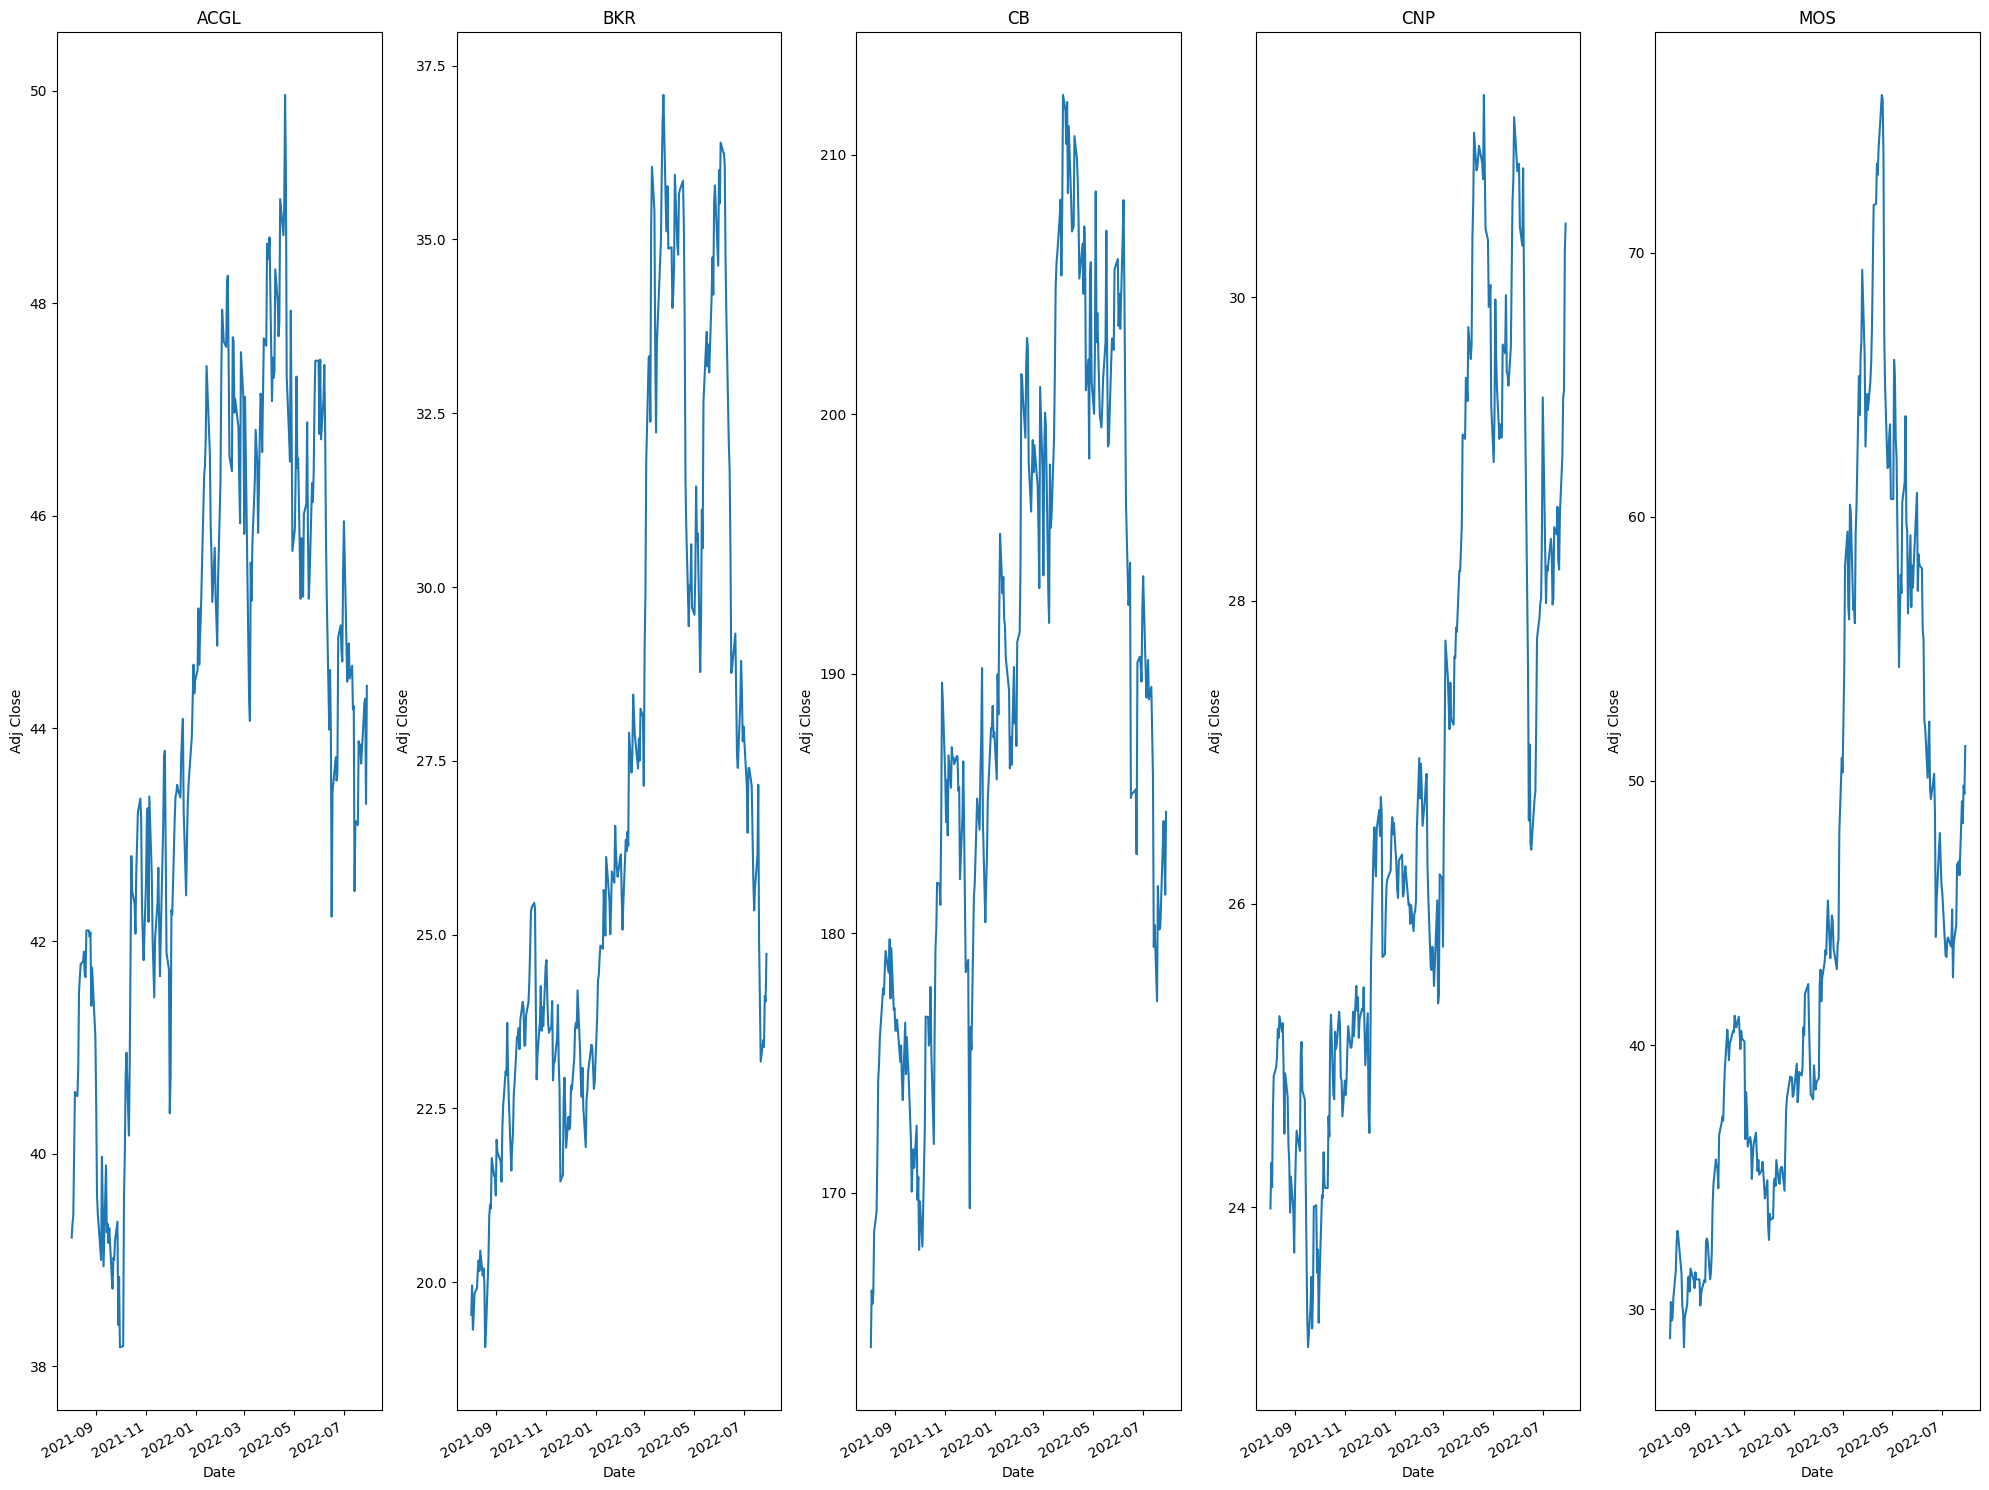

In [99]:
# Plot 찍어보기
# 상위 20개 종목 주가 불러오기
# 모멘텀 장,단점 -> 듀얼 모멘텀의 한계를 보완한 새로운 전략으로 종목 선정 후 필터링

df_mmt = yf.download(list(result_asset['ticker']), start_date, end_date)['Adj Close']

num_plots = len(df_mmt.columns)
num_cols = 5
num_rows = (num_plots // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
fig.subplots_adjust(hspace=0.5)

for i, (col, ax) in enumerate(zip(df_mmt.columns, axes.flatten())):
    df_mmt[col].plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Date')
    ax.set_ylabel('Adj Close')

for i in range(num_plots, num_rows * num_cols):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

## Backtest

In [108]:
start_date_t = '2022-09-01'
end_date_t = '2023-03-01'

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def max_sharpe(dict, start_date, end_date):
    df = yf.download(list(dict['ticker']), start_date, end_date)['Adj Close']

    mu = expected_returns.mean_historical_return(df) # pfo mean 
    S = risk_models.sample_cov(df) # cov
    ef = EfficientFrontier(mu, S)

    n_assets = len(mu)  # 자산 수
    min_weights = 0.5 * 1 / n_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / n_assets

    for asset in mu.index:
        num = mu.index.get_loc(asset)
        ef.add_constraint(lambda w: w[num] <= max_weights)
        ef.add_constraint(lambda w: w[num] >= min_weights)
    
    ef.add_constraint(lambda w: w.sum() == 1)

    w_opt = ef.max_sharpe() # Max Sharpe ratio가 되는 weights 찾기

    w_clean = ef.clean_weights()
    print()
    ef.portfolio_performance(verbose=True) 
    # print(w_clean) # 가중치 확인
    max_weight_asset = max(w_clean, key=w_clean.get)
    max_weight_value = w_clean[max_weight_asset]

    print()
    print("가장 큰 가중치를 가진 자산:", max_weight_asset)
    print("가장 큰 가중치:", max_weight_value)

    return w_clean
    
rst_dict = max_sharpe(result_asset, start_date, end_date)
krat_dict = max_sharpe(krat_df_20, start_date, end_date)

[*********************100%%**********************]  9 of 9 completed

Expected annual return: 39.0%
Annual volatility: 21.2%
Sharpe Ratio: 1.74

가장 큰 가중치를 가진 자산: UNH
가장 큰 가중치: 0.22222
[*********************100%%**********************]  20 of 20 completed

Expected annual return: 85.8%
Annual volatility: 24.8%
Sharpe Ratio: 3.38

가장 큰 가중치를 가진 자산: DVN
가장 큰 가중치: 0.1


In [109]:
def max_sharpe_cum_ret(dic, result, start_date, end_date):
    data = df = yf.download(list(dic['ticker']), start_date, end_date)['Adj Close']
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    return cum_ret

rst_cum = max_sharpe_cum_ret(result_asset, rst_dict, start_date_t, end_date_t)
krat_cum = max_sharpe_cum_ret(krat_df_20, krat_dict, start_date_t, end_date_t)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  20 of 20 completed


In [110]:
nasdaq = yf.download('^IXIC', start_date_t, end_date_t)['Adj Close']
nasdaq_ret = nasdaq.pct_change().dropna()
nas_cum = (1 + nasdaq_ret).cumprod()

[*********************100%%**********************]  1 of 1 completed


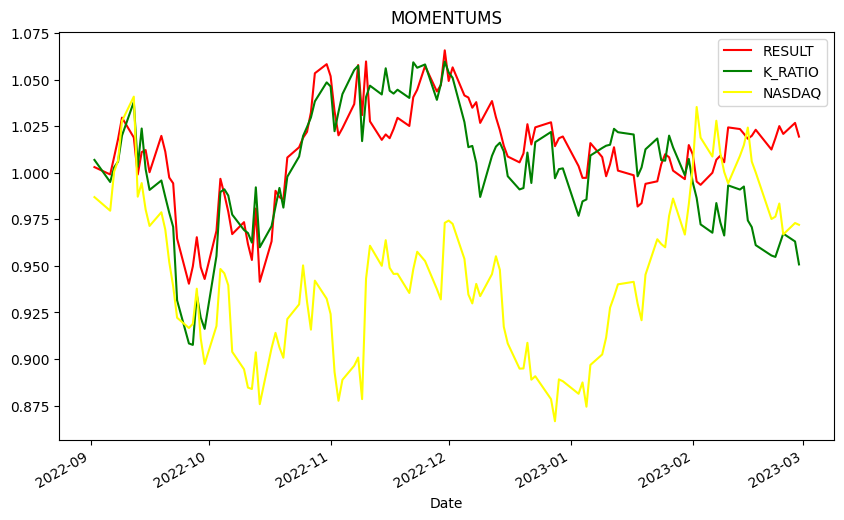

In [111]:
plt.figure(figsize=(10,6))
plt.title("MOMENTUMS")

rst_cum.plot(label='RESULT', color='red')
krat_cum.plot(label='K_RATIO', color='green')
nas_cum.plot(label='NASDAQ', color='yellow')

plt.legend()
plt.show()